In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# Purpose
The purpose of this analysis is to determine whether or not correlation exists between player weight and/or height & performance w.r.t their position; the presence of correlation would indicate that a player's physical measurements are a significantly impactful variable when predicting a player's potential productivity.

# Methodology
Players will be grouped by their position (Forwards, Defense, Goalies) to reflect position-specific size attributes for height and weight; the performance metrics each position will reflect following position-specific metrics:

Forwards are expected to produce Points
Defense are expected to maintain a positive Plus-Minus rating
Goalies are expected to maintain a high Winning Percentage

### Data Import, Merge & Clean

In [2]:
# Read the Master.csv file into a pandas DataFrame
master_df = pd.read_csv("Master.csv")

# Read the Scoring.csv file into another pandas DataFrame
scoring_df = pd.read_csv("Scoring.csv")

# Merge the two DataFrames on the 'playerID' column
all_players_merged = pd.merge(master_df, scoring_df, on="playerID", how="inner", suffixes=('_master', '_scoring'))

# Drop the duplicate 'pos_scoring' column
all_players_merged.drop('pos_scoring', axis=1, inplace=True)

# Rename columns to remove the _master suffixes
all_players_merged.rename(lambda x: x.replace('_master', ''), axis=1, inplace=True)

# Remove rows with null values in 'height', 'weight', or games played columns
all_players_merged = all_players_merged.dropna(subset=['height', 'weight', 'GP'])

# Fill remaining null values with 0
all_players_merged.fillna(0, inplace=True)

# Remove rows with 5 or fewer games played
all_players_df = all_players_merged[all_players_merged['GP'] > 5]

# Separate players into different categories based on their positions
forwards_df = all_players_df[all_players_df['pos'].isin(['C', 'L', 'R'])]
defense_df = all_players_df[all_players_df['pos'] == 'D']

# Read the Goalies.csv file into another pandas DataFrame
goalies_data = pd.read_csv("Goalies.csv")

# Merge goalies with additional data from Goalies.csv
goalies_merged = pd.merge(master_df, goalies_data, on="playerID", how="inner")

# Drop rows with missing values in 'height', 'weight', and 'GP' columns
goalies_df = goalies_merged.dropna(subset=['height', 'weight', 'GP'])

## Historical Population Averages: Player Height & Player Weight

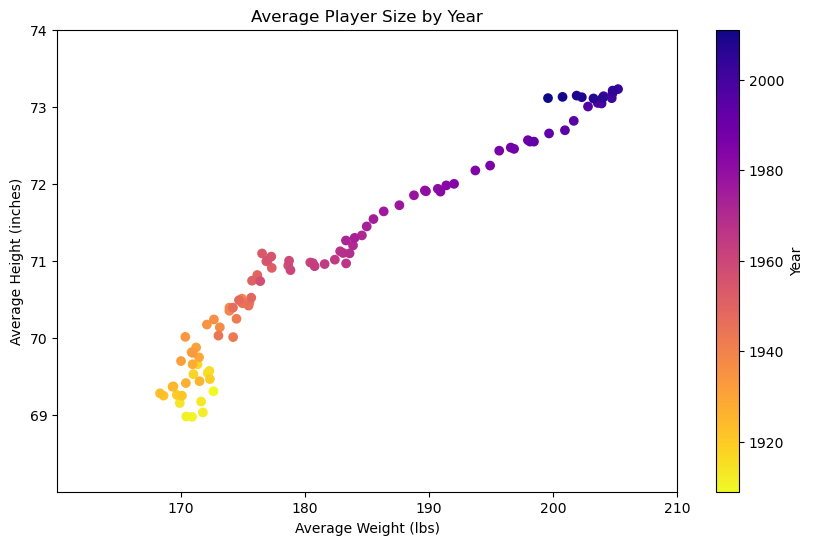

In [3]:
# Define colormap
cmap = cm.plasma.reversed()  # Choose a colormap (e.g., 'viridis', 'plasma', 'inferno', 'magma')

# Compute average height and weight by year
avg_height_weight_yearly = all_players_df.groupby('year').agg({
    'height': 'mean',
    'weight': 'mean'
}).reset_index()

# Normalize years to range [0, 1]
min_year = avg_height_weight_yearly['year'].min()
max_year = avg_height_weight_yearly['year'].max()
norm = plt.Normalize(min_year, max_year)

# Create scatter plot with colormap
plt.figure(figsize=(10, 6))
sc = plt.scatter(x='weight', y='height', data=avg_height_weight_yearly, c='year', cmap=cmap, norm=norm)
plt.colorbar(sc, label='Year')

# Set labels and title
plt.xlabel('Average Weight (lbs)')
plt.ylabel('Average Height (inches)')
plt.title('Average Player Size by Year')

# Set x-axis and y-axis ranges
plt.xlim(160, 210)
plt.ylim(68, 74)

# Remove tick labels at the origin
plt.xticks(ticks=plt.xticks()[0][1:])
plt.yticks(ticks=plt.yticks()[0][1:])

# Show plot
plt.show()

### Historical population data appears to show an upwards trend in player size over the years

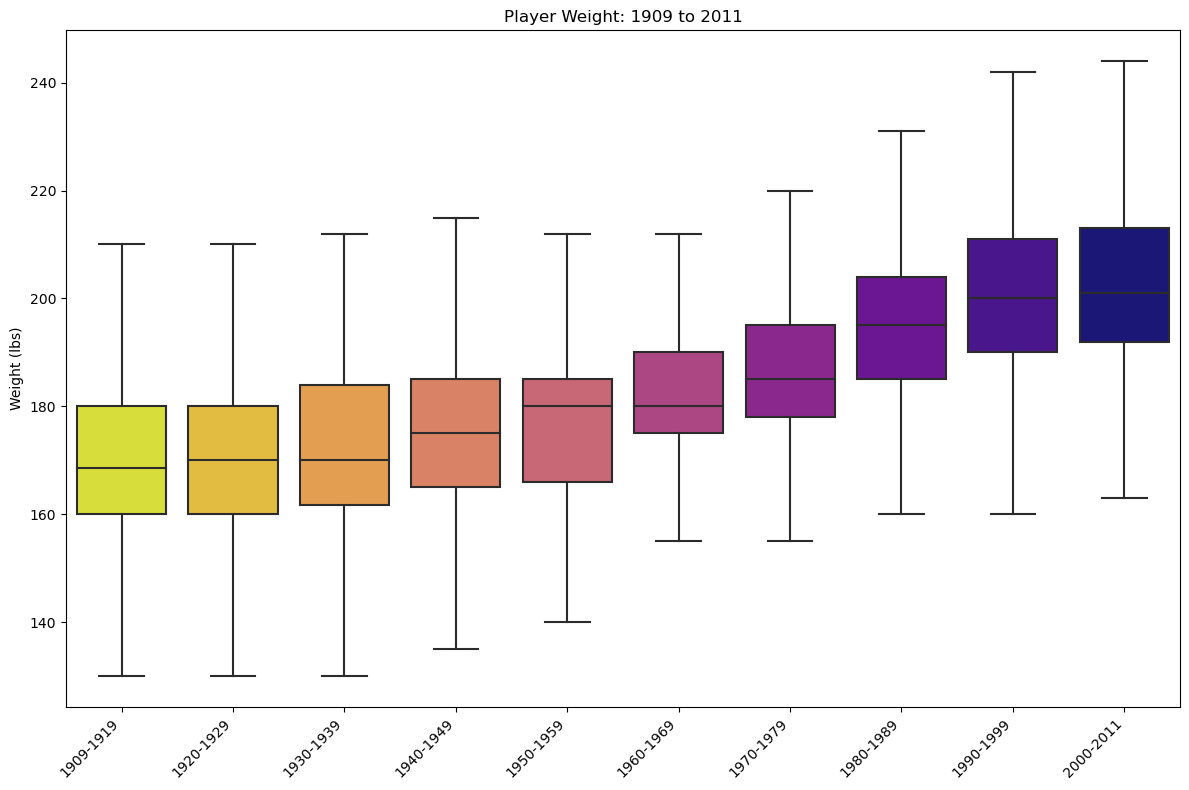

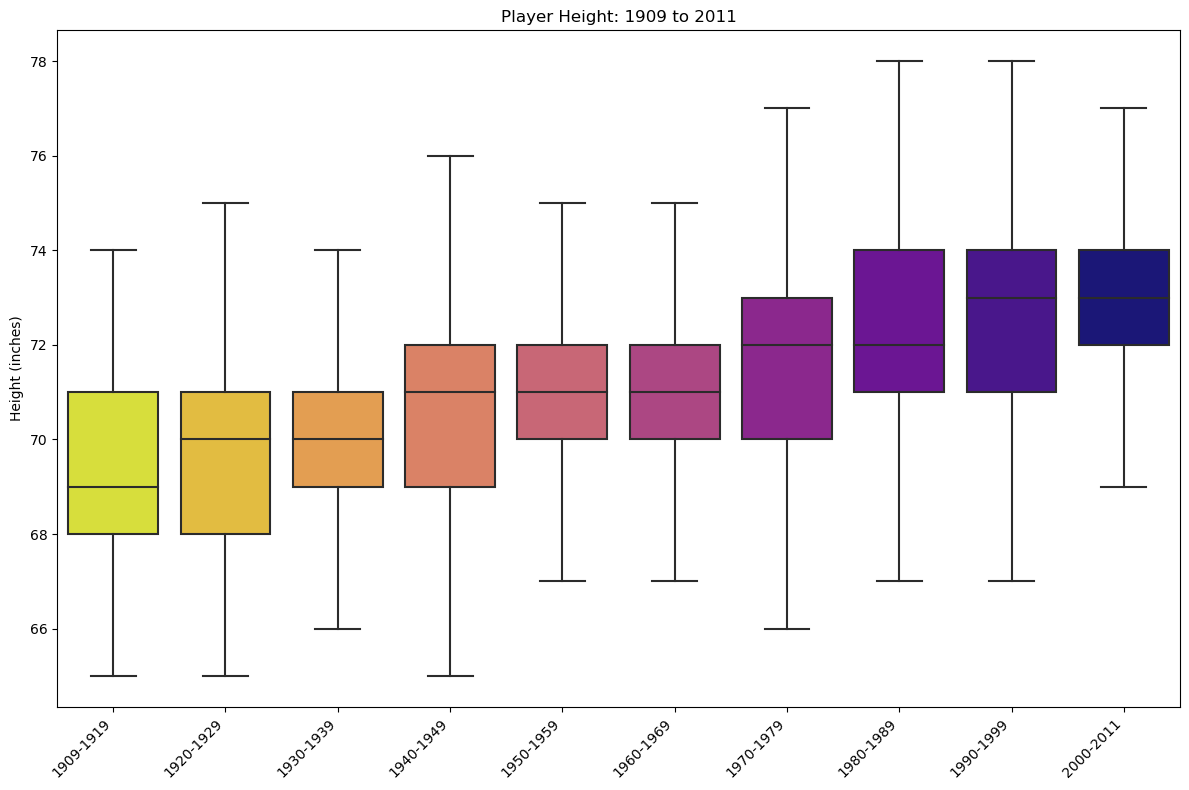

In [4]:
# Define the year ranges
year_ranges = [(1909, 1919), (1920, 1929), (1930, 1939), (1940, 1949), (1950, 1959),
               (1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), (2000, 2011)]

# Extract colors from the colormap object
colors = [cmap(i) for i in np.linspace(0, 1, len(year_ranges))]

# Create a boxplot for weight grouped by year ranges
plt.figure(figsize=(12, 8))
sns.boxplot(x=pd.cut(all_players_merged['year'], bins=[year[0] for year in year_ranges] + [2012], labels=[f"{year[0]}-{year[1]}" for year in year_ranges]),
            y='weight', data=all_players_merged, palette=colors, showfliers=False)

# Set labels and title
plt.xlabel('')
plt.ylabel('Weight (lbs)')
plt.title('Player Weight: 1909 to 2011')


# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

# Create a boxplot for height grouped by year ranges
plt.figure(figsize=(12, 8))
sns.boxplot(x=pd.cut(all_players_merged['year'], bins=[year[0] for year in year_ranges] + [2012], labels=[f"{year[0]}-{year[1]}" for year in year_ranges]),
            y='height', data=all_players_merged, palette=colors, showfliers=False)

# Set labels and title
plt.xlabel('')
plt.ylabel('Height (inches)')
plt.title('Player Height: 1909 to 2011')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

### Independently, both player height and player weight appear to show an upwards trend over the years

# Linear Regression Analysis

### Forward Weight vs Forward Points & Forward Height vs Forward Points

Regression Results for weight vs Pts:
                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.794
Date:                Fri, 31 May 2024   Prob (F-statistic):             0.0514
Time:                        12:42:20   Log-Likelihood:            -1.0973e+05
No. Observations:               23646   AIC:                         2.195e+05
Df Residuals:                   23644   BIC:                         2.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

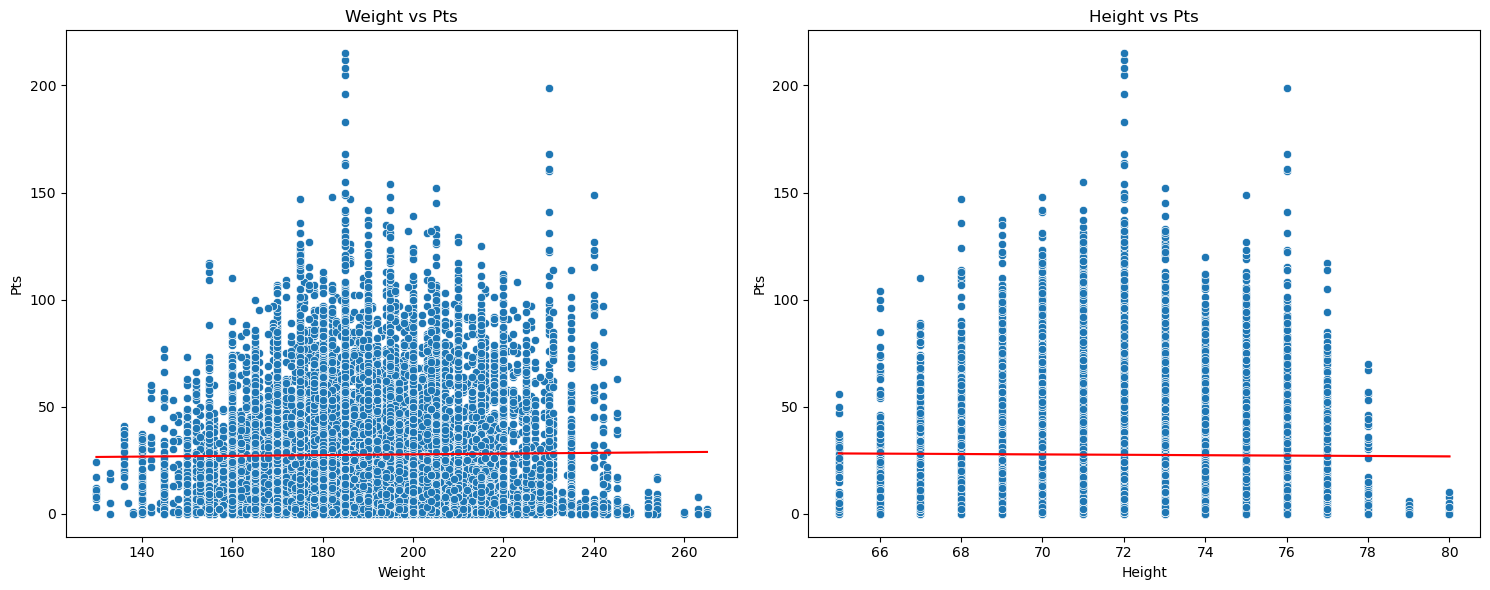

Weight vs Points R-squared: 0.0002, p-value: 0.0514
Height vs Points R-squared: 0.0001, p-value: 0.2142


In [5]:
# Define function to perform linear regression and plot results
def plot_regression(df, x_var, y_var, ax):
    # Perform linear regression
    X = df[x_var]
    y = df[y_var]
    X = sm.add_constant(X)  # Adds a constant term to the predictor

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    # Print important statistics
    print(f"Regression Results for {x_var} vs {y_var}:")
    print(model.summary())

    # Plot scatterplot and regression line
    sns.scatterplot(x=x_var, y=y_var, data=df, ax=ax)
    sns.lineplot(x=X[x_var], y=predictions, color='red', ax=ax)
    ax.set_title(f'{x_var.capitalize()} vs {y_var.capitalize()}')
    ax.set_xlabel(x_var.capitalize())
    ax.set_ylabel(y_var.capitalize())

    return model

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), tight_layout=True)

# First model: weight vs points
model_weight_forwards = plot_regression(forwards_df, 'weight', 'Pts', axes[0])

# Second model: height vs points
model_height_forwards = plot_regression(forwards_df, 'height', 'Pts', axes[1])

# Show plot
plt.show()

# Printing R-squared and p-values for both models
print(f"Weight vs Points R-squared: {model_weight_forwards.rsquared:.4f}, p-value: {model_weight_forwards.f_pvalue:.4f}")
print(f"Height vs Points R-squared: {model_height_forwards.rsquared:.4f}, p-value: {model_height_forwards.f_pvalue:.4f}")

### Low R-squared value & non-significant p-value suggests no statistical significance

In [6]:
# OLS Results suggest strong presence of multicollinearity
# Check correlation matrix for multicollinearity
corr_matrix = forwards_df[['weight', 'height', 'Pts']].corr()
print(corr_matrix)

          weight    height       Pts
weight  1.000000  0.771777  0.012666
height  0.771777  1.000000 -0.008078
Pts     0.012666 -0.008078  1.000000


### Strong positive correlation between weight and height (0.77)
### To account for multicollinearity, implement a composite measure (BMI)

In [7]:
# Assuming forwards_df is a slice of another DataFrame, make a copy to avoid warnings
forwards_df_bmi = forwards_df.copy()

# Convert height from inches to meters
forwards_df_bmi.loc[:, 'height_m'] = forwards_df_bmi['height'] * 0.0254

# Convert weight from pounds to kilograms
forwards_df_bmi.loc[:, 'weight_kg'] = forwards_df_bmi['weight'] * 0.453592

# Calculate BMI
forwards_df_bmi.loc[:, 'bmi_forwards'] = forwards_df_bmi['weight_kg'] / (forwards_df_bmi['height_m'] ** 2)

Regression Results for bmi_forwards vs Pts:
                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     24.15
Date:                Fri, 31 May 2024   Prob (F-statistic):           8.96e-07
Time:                        12:42:24   Log-Likelihood:            -1.0972e+05
No. Observations:               23646   AIC:                         2.195e+05
Df Residuals:                   23644   BIC:                         2.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
cons

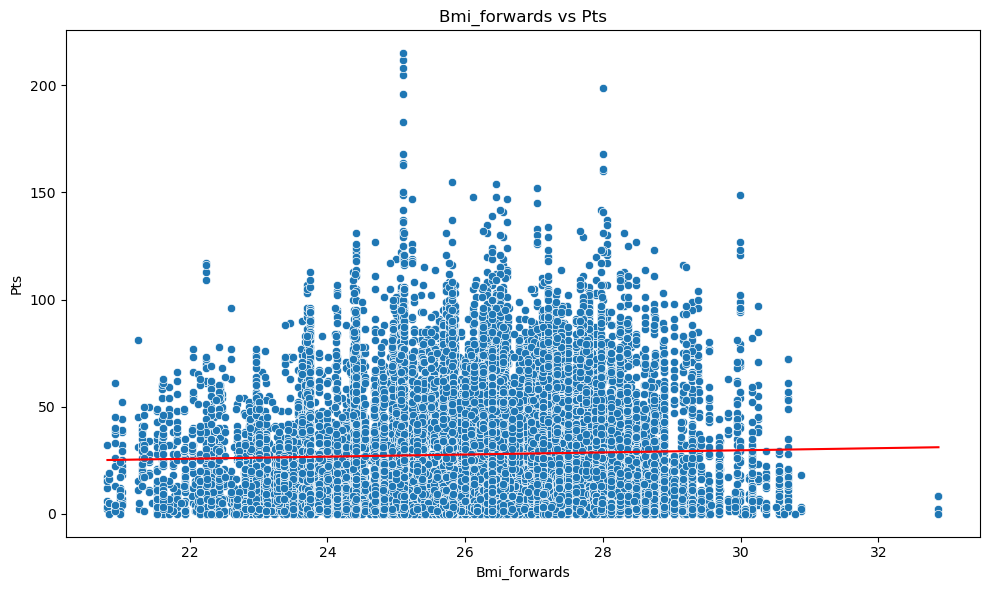

BMI vs Points R-squared: 0.0010, p-value: 0.0000


In [8]:
# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)

# Model: BMI vs points
model_bmi_forwards = plot_regression(forwards_df_bmi, 'bmi_forwards', 'Pts', axes)

# Show plot
plt.show()

# Printing R-squared and p-values for the BMI vs Points model
print(f"BMI vs Points R-squared: {model_bmi_forwards.rsquared:.4f}, p-value: {model_bmi_forwards.f_pvalue:.4f}")

#### 0.1% of points can be explained by BMI; p-value indicates statistical signficance but w.r.t the r-squared value, the regression model explains very little about the relationship between variables

### Defense Weight vs Defense PlusMinus & Defense Height vs Defense PlusMinus

Regression Results for weight vs +/-:
                            OLS Regression Results                            
Dep. Variable:                    +/-   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.853
Date:                Fri, 31 May 2024   Prob (F-statistic):            0.00886
Time:                        12:42:35   Log-Likelihood:                -48980.
No. Observations:               12296   AIC:                         9.796e+04
Df Residuals:                   12294   BIC:                         9.798e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

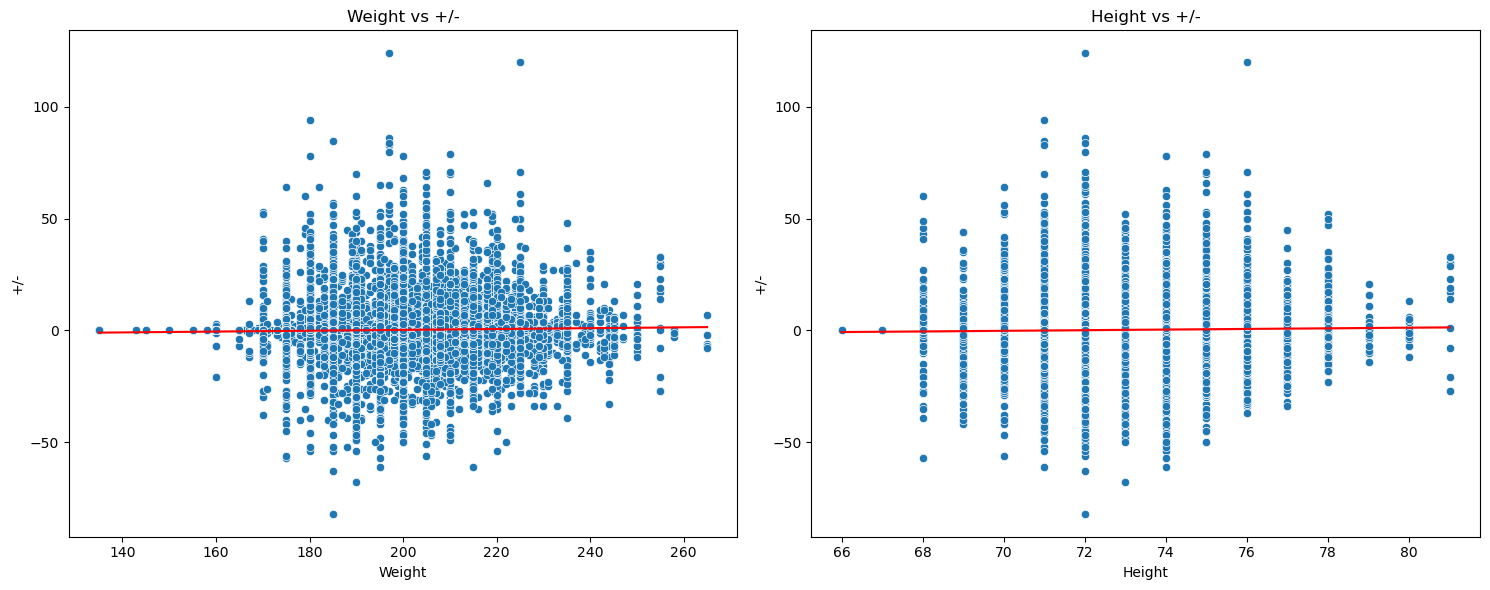

Weight vs +/- R-squared: 0.0006, p-value: 0.0089
Height vs +/- R-squared: 0.0005, p-value: 0.0118


In [9]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), tight_layout=True)

# First model: weight vs +/-
model_weight_defense = plot_regression(defense_df, 'weight', '+/-', axes[0])

# Second model: height vs +/-
model_height_defense = plot_regression(defense_df, 'height', '+/-', axes[1])

# Show plot
plt.show()

# Printing R-squared and p-values for both models
print(f"Weight vs +/- R-squared: {model_weight_defense.rsquared:.4f}, p-value: {model_weight_defense.f_pvalue:.4f}")
print(f"Height vs +/- R-squared: {model_height_defense.rsquared:.4f}, p-value: {model_height_defense.f_pvalue:.4f}")

#### P-value indicates statistical signficance but w.r.t the r-squared value, the regression model has little to no explanatory power even if p value is less than alpha

Regression Results for bmi_defense vs Pts:
                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     31.68
Date:                Fri, 31 May 2024   Prob (F-statistic):           1.86e-08
Time:                        12:42:38   Log-Likelihood:                -51320.
No. Observations:               12296   AIC:                         1.026e+05
Df Residuals:                   12294   BIC:                         1.027e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const  

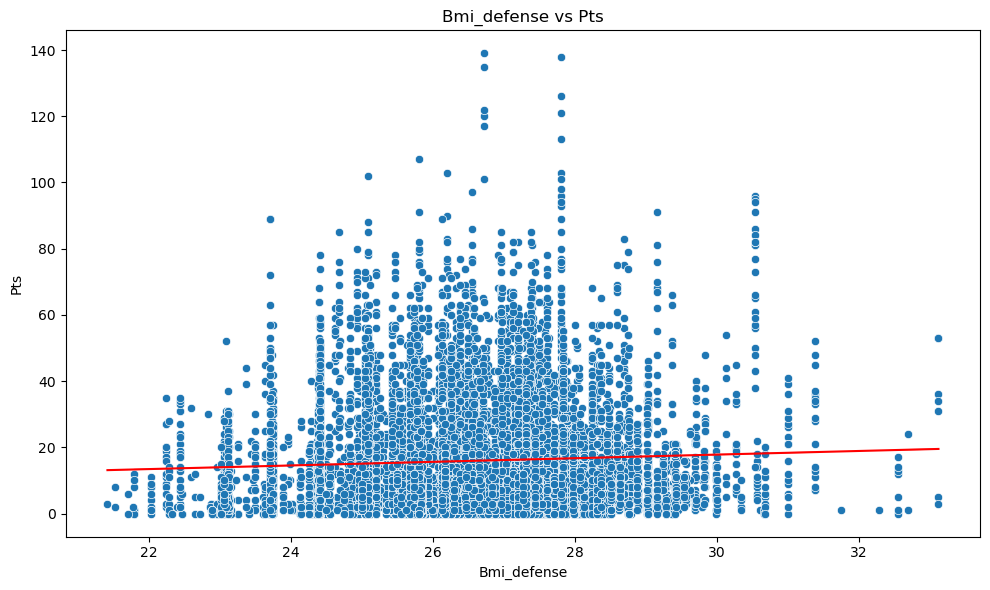

BMI vs +/- R-squared: 0.0026, p-value: 0.0000


In [10]:
# Assuming defense_df is a slice of another DataFrame, make a copy to avoid warnings
defense_df_bmi = defense_df.copy()

# Convert height from inches to meters
defense_df_bmi.loc[:, 'height_m'] = defense_df_bmi['height'] * 0.0254

# Convert weight from pounds to kilograms
defense_df_bmi.loc[:, 'weight_kg'] = defense_df_bmi['weight'] * 0.453592

# Calculate BMI
defense_df_bmi.loc[:, 'bmi_defense'] = defense_df_bmi['weight_kg'] / (defense_df_bmi['height_m'] ** 2)

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)

# Model: BMI vs +/-
model_bmi_defense = plot_regression(defense_df_bmi, 'bmi_defense', 'Pts', axes)

# Show plot
plt.show()

# Printing R-squared and p-values for the BMI vs +/- model
print(f"BMI vs +/- R-squared: {model_bmi_defense.rsquared:.4f}, p-value: {model_bmi_defense.f_pvalue:.4f}")

#### P-value indicates statistical significance however R-squared value indicates very little explanatory power

### Goalie Weight vs Goalie Win % & Goalie Height vs Goalie Win %

Regression Results for weight vs win_percentage:
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.102
Date:                Fri, 31 May 2024   Prob (F-statistic):              0.294
Time:                        12:42:46   Log-Likelihood:                 1656.6
No. Observations:                3225   AIC:                            -3309.
Df Residuals:                    3223   BIC:                            -3297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

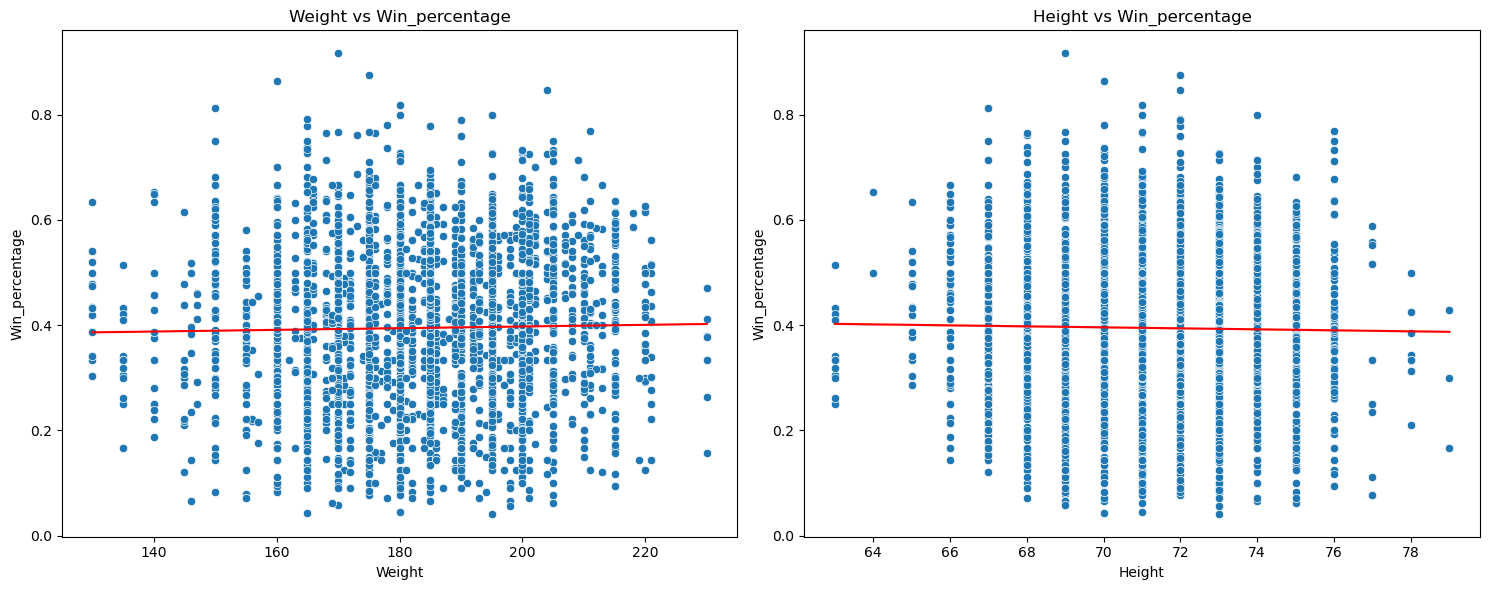

Weight vs Win % R-squared: 0.0003, p-value: 0.2940
Height vs Win % R-squared: 0.0003, p-value: 0.3546


In [11]:
# Assuming goalies_df is already defined and populated with data
# Create a copy of goalies_df to avoid SettingWithCopyWarning
goalies_df_copy = goalies_df.copy()

# Calculate winning percentage
goalies_df_copy.loc[:, 'win_percentage'] = goalies_df_copy['W'] / goalies_df_copy['GP']

# Filter out rows where win_percentage is equal to 0.0, 1.0, and GP is 5 or less
filtered_goalies_df = goalies_df_copy[(goalies_df_copy['win_percentage'] != 0.0) & 
                                      (goalies_df_copy['win_percentage'] != 1.0) &
                                      (goalies_df_copy['GP'] > 5)]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), tight_layout=True)

# First model: weight vs win %
model_weight_goalies = plot_regression(filtered_goalies_df, 'weight', 'win_percentage', axes[0])

# Second model: height vs win %
model_height_goalies = plot_regression(filtered_goalies_df, 'height', 'win_percentage', axes[1])

# Show plot
plt.show()

# Printing R-squared and p-values for both models
print(f"Weight vs Win % R-squared: {model_weight_goalies.rsquared:.4f}, p-value: {model_weight_goalies.f_pvalue:.4f}")
print(f"Height vs Win % R-squared: {model_height_goalies.rsquared:.4f}, p-value: {model_height_goalies.f_pvalue:.4f}")

#### Both the R-squared value and p-value indicate that the regression model has little explanatory power

Regression Results for bmi_goalies vs win_percentage:
                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.099
Date:                Fri, 31 May 2024   Prob (F-statistic):             0.0136
Time:                        12:42:49   Log-Likelihood:                 1659.1
No. Observations:                3225   AIC:                            -3314.
Df Residuals:                    3223   BIC:                            -3302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

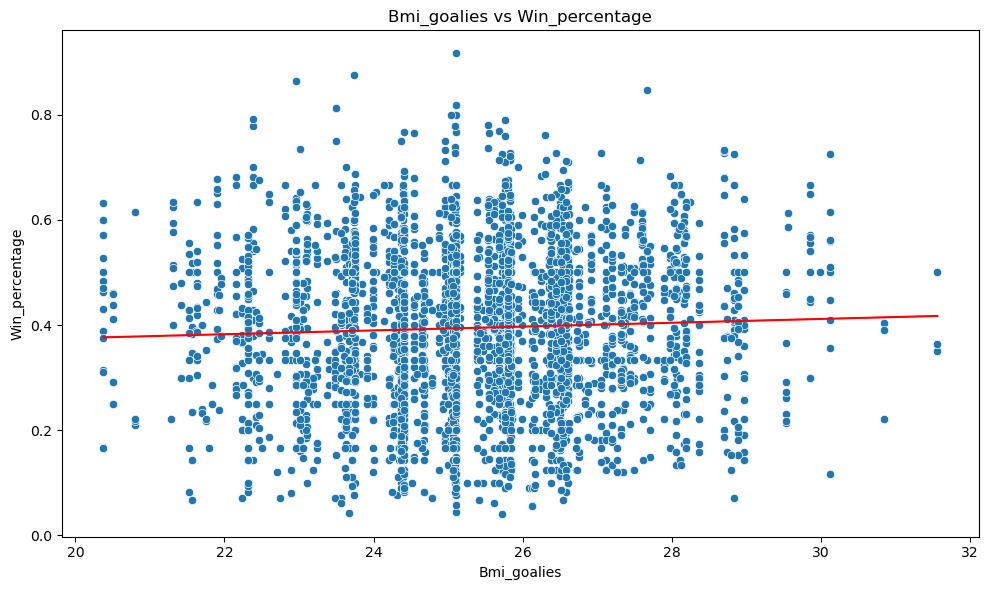

BMI vs Winning % R-squared: 0.0019, p-value: 0.0136


In [12]:
# Assuming filtered_goalies_df is a slice of another DataFrame, make a copy to avoid warnings
filtered_goalies_df_bmi = filtered_goalies_df.copy()

# Convert height from inches to meters
filtered_goalies_df_bmi.loc[:, 'height_m'] = filtered_goalies_df_bmi['height'] * 0.0254

# Convert weight from pounds to kilograms
filtered_goalies_df_bmi.loc[:, 'weight_kg'] = filtered_goalies_df_bmi['weight'] * 0.453592

# Calculate BMI
filtered_goalies_df_bmi.loc[:, 'bmi_goalies'] = filtered_goalies_df_bmi['weight_kg'] / (filtered_goalies_df_bmi['height_m'] ** 2)

# Create subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)

# Model: BMI vs Win %
model_bmi_goalies = plot_regression(filtered_goalies_df_bmi, 'bmi_goalies', 'win_percentage', axes)

# Show plot
plt.show()

# Printing R-squared and p-values for the BMI vs Win % model
print(f"BMI vs Winning % R-squared: {model_bmi_goalies.rsquared:.4f}, p-value: {model_bmi_goalies.f_pvalue:.4f}")

#### P-value indicates statistical significance however R-squared value indicates very little explanatory power

# Results
## Linear regression models for all position groups and their respective performance metrics appear to be statistically insignificant with little to no predictive or explanatory power
## Strong correlation between height and weight suggests there may be more complex underlying relationships between player size and performance metrics

# Next Steps
### - Polynomial Regression
### - Splines